$$L_{TripletContrastive} = \alpha([d(a, p) - d(a, n) + m_{triplet}]_+) \\ + (1-\alpha)([d(a, p) - m_{pos}]_+ + [m_{neg} - d(a, n))]_+)$$

In [1]:
experiment_name = 'TripletContrastive weighted'

# Install and import

In [2]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

In [3]:
%matplotlib inline
from tqdm import trange
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import os
from torchvision.datasets.folder import default_loader
import datetime


logging.getLogger().setLevel(logging.INFO)

In [4]:
%load_ext tensorboard

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
from src import params
from src.dataset import (get_transforms, get_cub_2011, get_cub_2011_class_disjoint, get_inverse_transform)
from src.models import (get_embedder, get_trunk)
from src.training import (get_optimizers, get_loss, get_miner, get_sampler, get_testing_hooks)
from src.utils import get_experiment_id, git_version
from src.evaluation import get_inference_model, get_scores, get_embeddings

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
print("Git commit hash", git_version())

Git commit hash 44f438733b4b033710f50e72c6a5e5935789f9ad


# Experiment parameters

In [10]:
params.get_params()

{'embedder_layers': [512, 256],
 'batch_size': 32,
 'num_epochs': 40,
 'test_interval': 5,
 'patience': 2}

# Prepare for training

## Dataset

In [11]:
train_transform, val_transform = get_transforms()

In [12]:
original_train, original_val = get_cub_2011()

In [13]:
train_dataset, val_dataset = get_cub_2011_class_disjoint(train_transform, val_transform)

## Model

In [14]:
trunk, trunk_output_size = get_trunk(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)

## Optimizers

In [15]:
trunk_optimizer, embedder_optimizer = get_optimizers(trunk, embedder)

# Custom loss

In [16]:
from pytorch_metric_learning.losses.generic_pair_loss import GenericPairLoss
from pytorch_metric_learning.losses.base_metric_loss_function import BaseMetricLossFunction
from pytorch_metric_learning.utils import loss_and_miner_utils as lmu
from pytorch_metric_learning.reducers import AvgNonZeroReducer

# Warning: works only with distances, not similarities
class TripletContrastiveLoss(BaseMetricLossFunction):
    def __init__(
        self,
        pos_margin=0.5,
        neg_margin=0.5,
        triplet_margin=0.1,
        alpha=0.1,
        triplets_per_anchor="all",
        distance_norm=2,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.pos_margin = pos_margin
        self.neg_margin = neg_margin
        self.triplet_margin = triplet_margin
        self.alpha = alpha
        self.triplets_per_anchor = triplets_per_anchor
        self.distance_norm = distance_norm
        
        self.add_to_recordable_attributes(list_of_names=["num_non_zero_pos_pairs", "num_non_zero_neg_pairs"])
        self.add_to_recordable_attributes(name="num_non_zero_triplets_triplet_loss_only")
        self.add_to_recordable_attributes(name="num_non_zero_triplets")
    
    def compute_loss(self, embeddings, labels, indices_tuple):
        self.num_non_zero_pos_pairs, self.num_non_zero_neg_pairs = 0, 0
        self.num_non_zero_triplets_triplet_loss_only = 0
        self.num_non_zero_triplets = 0
            
        indices_tuple = lmu.convert_to_triplets(indices_tuple, labels, t_per_anchor=self.triplets_per_anchor)
        
        anchor_idx, positive_idx, negative_idx = indices_tuple
        if len(anchor_idx) == 0:
            return self.zero_losses()
        
        anchors, positives, negatives = embeddings[anchor_idx], embeddings[positive_idx], embeddings[negative_idx]

        a_p_dist = F.pairwise_distance(anchors, positives, self.distance_norm)
        a_n_dist = F.pairwise_distance(anchors, negatives, self.distance_norm)
        p_n_dist = F.pairwise_distance(positives, negatives, self.distance_norm)
        
        #print('AP', a_p_dist, 'AN', a_n_dist, 'PN', p_n_dist)
        dist = a_p_dist - a_n_dist
        
        # Compute triplet loss
        triplet_loss = F.relu(dist + self.triplet_margin)
        self.num_non_zero_triplets_triplet_loss_only = (triplet_loss > 0).nonzero().size(0)
        #print('Triplet loss', triplet_loss)
        
        # Compute pos contrastive loss
        contrastive_pos = F.relu(a_p_dist - self.pos_margin)
        self.num_non_zero_pos_pairs = (contrastive_pos > 0).nonzero().size(0)
        #print('Contrastive pos', contrastive_pos)
        
        # Compute neg contrastive loss
        contrastive_neg = F.relu(self.neg_margin - a_n_dist)
        self.num_non_zero_neg_pairs = (contrastive_neg > 0).nonzero().size(0)
        #print('Contrastive neg', contrastive_neg)
        
        full_loss = self.alpha*triplet_loss + (1-self.alpha)*(contrastive_pos + contrastive_neg) 
        self.num_non_zero_triplets = (full_loss > 0).nonzero().size(0)
        
        #print(full_loss)
        loss_dict = {"loss": {"losses": full_loss, "indices": anchor_idx, "reduction_type": "element"}}
        return loss_dict
        
    def get_default_reducer(self):
        return AvgNonZeroReducer()
    
test_embeddings = torch.Tensor([[1, 0], [1, 1], [0,1]])
test_labels = torch.Tensor([0, 0, 1])

test_loss_func = TripletContrastiveLoss(triplet_margin=0.1,
                                        pos_margin=0.5, 
                                        neg_margin=1, 
                                        alpha=0.1,
                                        triplets_per_anchor="all",
                                        distance_norm = 1)

# Far example
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.9],
                           [0.9,0]])
expected_loss = 0.46
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
assert np.isclose(true_loss, expected_loss), true_loss


# Simple useless
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.1],
                           [0.9,0]])
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
expected_loss = 0.09
assert np.isclose(true_loss, expected_loss), true_loss

# Simple useful
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.4],
                           [0.1,0]])
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
expected_loss = 0.85
assert np.isclose(true_loss, expected_loss), true_loss


# Very simple useful
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.9],
                           [0.1,0]])
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
expected_loss = 1.26
assert np.isclose(true_loss, expected_loss), true_loss

# Margin not violated
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.4],
                           [0.5,0]])
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
expected_loss = 0.45
assert np.isclose(true_loss, expected_loss), true_loss

# Hard
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.5],
                           [0.4, 0]])
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
expected_loss = 0.56
assert np.isclose(true_loss, expected_loss), true_loss

# Very hard
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.15],
                           [0.1, 0]])
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
expected_loss = 0.825
assert np.isclose(true_loss, expected_loss), true_loss

# Ideal
test_embeddings = torch.Tensor([[0, 0], 
                           [0.0, 0.0],
                           [1.0, 0]])
true_loss = test_loss_func.compute_loss(test_embeddings, test_labels, indices_tuple = ([0], [1], [2]))['loss']['losses'].item()
expected_loss = 0
assert np.isclose(true_loss, expected_loss), true_loss


<ipython-input-16-a7f232d31e8e>:52: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  self.num_non_zero_triplets_triplet_loss_only = (triplet_loss > 0).nonzero().size(0)


## Loss, miner, sampler


In [17]:
loss = TripletContrastiveLoss(triplet_margin=0.1,
                                pos_margin=0.9, 
                                neg_margin=0.9,
                                alpha=0.2,
                                triplets_per_anchor="all",
                                distance_norm = 1)
miner = get_miner()
sampler = get_sampler(train_dataset)

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {}# {"tuple_miner": miner}

optimizers, loss_funcs, mining_funcs

({'trunk_optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 1e-05
      weight_decay: 0.0001
  ),
  'embedder_optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0.0001
  )},
 {'metric_loss': TripletContrastiveLoss(
    (reducer): AvgNonZeroReducer()
  )},
 {})

# Train the model

In [18]:
%tensorboard --logdir "experiment_logs/tensorboard"

Reusing TensorBoard on port 6006 (pid 60421), started 0:29:31 ago. (Use '!kill 60421' to kill it.)

In [19]:
experiment_id = get_experiment_id(experiment_name)
experiment_dir = os.path.join('experiment_logs', experiment_id)

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
total_loss=0.07012: 100%|██████████| 173/173 [00:21<00:00,  8.14it/s]
INFO:root:TRAINING EPOCH 2
total_loss=0.05969: 100%|██████████| 173/173 [00:22<00:00,  7.74it/s]
INFO:root:TRAINING EPOCH 3
total_loss=0.06377: 100%|██████████| 173/173 [00:22<00:00,  7.73it/s]
INFO:root:TRAINING EPOCH 4
total_loss=0.05974: 100%|██████████| 173/173 [00:20<00:00,  8.37it/s]
INFO:root:TRAINING EPOCH 5
total_loss=0.09312: 100%|██████████| 173/173 [00:20<00:00,  8.49it/s]
INFO:root:Evaluating epoch 5
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:09<00:00, 19.29it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


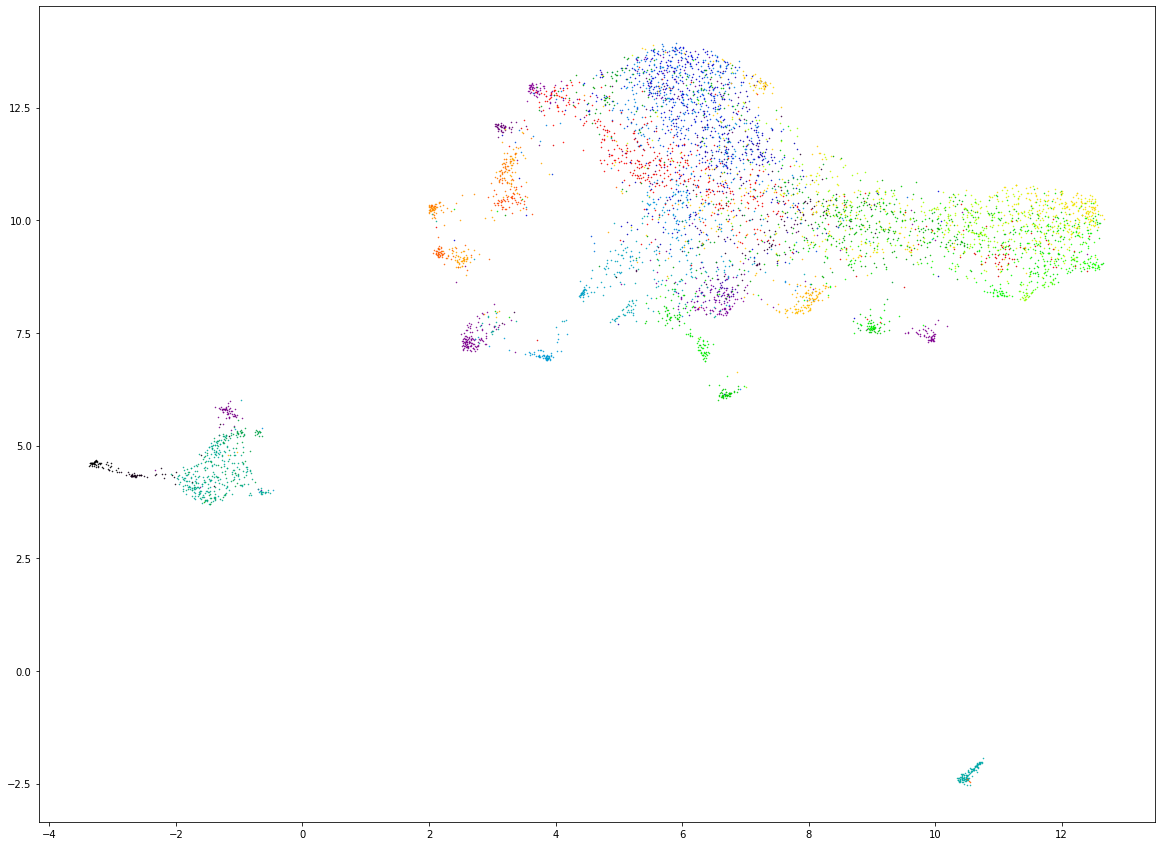

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:New best accuracy! 0.1259403466534196
INFO:root:TRAINING EPOCH 6
total_loss=0.05167: 100%|██████████| 173/173 [00:21<00:00,  8.17it/s]
INFO:root:TRAINING EPOCH 7
total_loss=0.05255: 100%|██████████| 173/173 [00:21<00:00,  8.01it/s]
INFO:root:TRAINING EPOCH 8
total_loss=0.03908: 100%|██████████| 173/173 [00:20<00:00,  8.41it/s]
INFO:root:TRAINING EPOCH 9
total_loss=0.10811: 100%|██████████| 173/173 [00:21<00:00,  8.17it/s]
INFO:root:TRAINING EPOCH 10
total_loss=0.06138: 100%|██████████| 173/173 [00:21<00:00,  8.00it/s]
INFO:root:Evaluating epoch 10
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 17.18it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


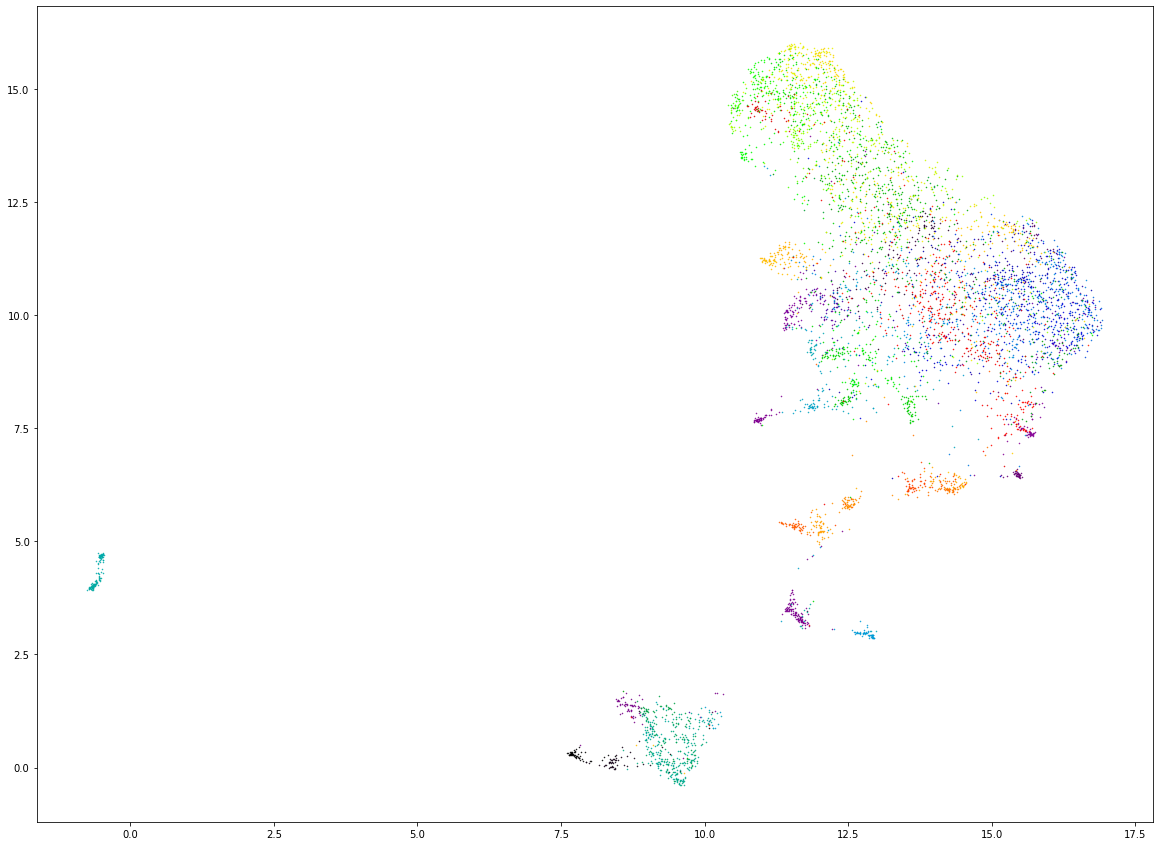

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Validation accuracy has plateaued. Exiting.


In [20]:
end_of_epoch_hook, end_of_iteration_hook = get_testing_hooks(experiment_id, val_dataset, params.test_interval, params.patience)
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                params.batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 4,
                                end_of_iteration_hook = end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_hook)

trainer.train(num_epochs=params.num_epochs)

In [21]:
torch.save(embedder.state_dict(), os.path.join(experiment_dir, 'embedder.pt'))
torch.save(trunk.state_dict(), os.path.join(experiment_dir, 'trunk.pt'))

In [22]:
print('Best models')
best_embedder, best_trunk = [os.path.join(experiment_dir, fname) for fname in os.listdir(experiment_dir) if 'embedder_best' in fname][0], [os.path.join(experiment_dir, fname) for fname in os.listdir(experiment_dir) if 'trunk_best' in fname][0]

best_embedder, best_trunk

Best models


('experiment_logs/09-07_16:52_TripletContrastive weighted/embedder_best5.pth',
 'experiment_logs/09-07_16:52_TripletContrastive weighted/trunk_best5.pth')

In [23]:
trunk, trunk_output_size = get_trunk(device)
trunk.load_state_dict(torch.load(best_trunk))
trunk = trunk.to(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)
embedder.load_state_dict(torch.load(best_embedder))
embedder = embedder.to(device)

# Evaluate results

In [24]:
gallery_dataset = original_train
query_dataset = original_val
gallery_dataset.transform = val_transform
query_dataset.transform = val_transform

gallery_labels = np.array([gallery_dataset.target(i) for i in range(len(gallery_dataset))])
query_labels = np.array([query_dataset.target(i) for i in range(len(query_dataset))])

In [25]:
inference_model = get_inference_model(trunk, embedder)

In [26]:
gallery_embeddings = get_embeddings(inference_model, gallery_dataset)
query_embeddings = get_embeddings(inference_model, query_dataset)

100%|██████████| 5794/5794 [00:35<00:00, 165.01it/s]


In [27]:
get_scores(inference_model, gallery_embeddings, query_embeddings, gallery_labels, query_labels)

INFO:root:running k-nn with k=30
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=200
INFO:root:embedding dimensionality is 256


{'AMI': 0.48680445004583783,
 'NMI': 0.6784235177899263,
 'mean_average_precision_at_r': 0.16777568209854066,
 'precision_at_1': 0.4677252329996548,
 'r_precision': 0.27281115224231167}

## Visual evaluation

In [28]:
inv_normalize = get_inverse_transform()

def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataset = val_dataset

In [29]:
class_a = dataset.targets[0]
class_b = dataset.targets[100]

class_a_idx = (dataset.targets == class_a).nonzero()[0]
class_b_idx = (dataset.targets == class_b).nonzero()[0]

In [30]:
class_a_idx[:10], class_b_idx[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

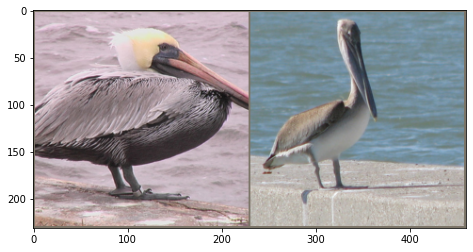

Same class


In [31]:
# compare two images of the same class
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_a_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)

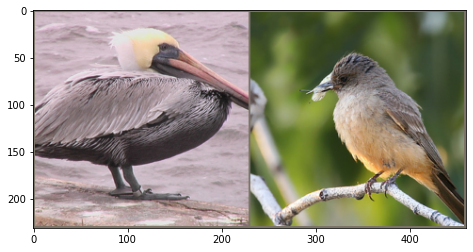

Same class


In [32]:
# compare two images of different classes
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_b_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)

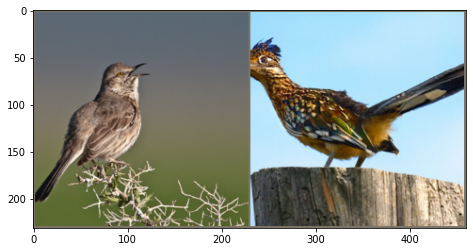

Same class
Actually different


In [33]:
# compare two random images
idx1 = np.random.choice(range(len(dataset)))
idx2 = np.random.choice(range(len(dataset)))
(x, x_label), (y, y_label) = dataset[idx1], dataset[idx2]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)
print('Actually same' if x_label==y_label else "Actually different")

## Retrieval

In [34]:
inference_model.train_indexer(gallery_images, 256)

AttributeError: 'InferenceModel' object has no attribute 'train_indexer'

In [ ]:
k = 5
query_idx = np.random.randint(0, len(gallery_dataset))
query_img = gallery_dataset[query_idx][0]
query_batch =  [query_img]
# D, I = index.search(query_batch, k)
# print(D)

I, D = inference_model.get_nearest_neighbors(query_batch, k=k)
print(D)
neighbors_idx = I[0]
neighbors_imgs = [gallery_dataset[i][0] for i in neighbors_idx]
neighbors_labels = gallery_labels[neighbors_idx]

imshow(query_img)

imshow(torchvision.utils.make_grid(torch.stack(neighbors_imgs, dim=0)))
print('Query label', gallery_labels[query_idx])
print('Neighbor labels', neighbors_labels)

In [ ]:
import itertools
from scipy.spatial.distance import pdist, cdist
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [ ]:
same_label_distances = {}
diff_label_distances = {}

def get_label_vectors(label):
    label_indices = np.array(range(len(gallery_labels)))[gallery_labels == label]
    vectors = [gallery_embeddings[i].numpy() for i in label_indices]    
    return vectors

for label in tqdm(set(gallery_labels)):
    vectors = get_label_vectors(label)

    distances = pdist(vectors, metric='cosine')
    same_label_distances[label] = distances
    
    diff_labels = list(set(gallery_labels).difference(set([label])))
    other_label = np.random.choice(diff_labels)
    other_vectors = get_label_vectors(other_label)
    
    other_distances_matrix = cdist(vectors, other_vectors)
    other_distances = []
    # Get upper triangle of matrix
    for i in range(len(other_distances_matrix)-1):
        other_distances.append(other_distances_matrix[i][i+1:])
    other_distances = np.concatenate(other_distances)
    
    diff_label_distances[(label, other_label)] = other_distances

In [ ]:
random_indices = np.random.choice(range(len(gallery_labels)), 1000)
random_distances = pdist(gallery_embeddings[random_indices].numpy(), metric='cosine')

In [ ]:
all_same_label_dists = np.concatenate([dists for l, dists in same_label_distances.items()])
all_diff_label_distances = np.concatenate([dists for l, dists in diff_label_distances.items()])

plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine')
plt.title("Distances distribution")
plt.legend()
plt.show()

In [ ]:
means = []
stds = []
for label, distances in same_label_distances.items():
    means.append(np.mean(distances))
    stds.append(np.std(distances))
    
sort_order = np.argsort(means)

labels = [label for label in same_label_distances]
sorted_labels = np.array(labels)[sort_order]

def autolabel(rects, text):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                text,
                ha='center', va='bottom')
        
fig, ax = plt.subplots(figsize=(25, 7))
width = 0.5
for i, label in enumerate(sorted_labels):
    distances = same_label_distances[label]
    rects = ax.bar(i, np.mean(distances), width, yerr=np.std(distances), align='center', alpha=0.5, ecolor='grey', capsize=5)
    autolabel(rects, f'{label}')
    
    ax.yaxis.grid(True)


plt.ylabel("Mean/std cosine dist within label")
plt.xlabel('Ranking by mean cosine dist within label, least to greatest')
# Save the figure and show
plt.title("Labels sorted by mean cosine. Some labels have bigger inter-class differences and variation")
plt.tight_layout()
plt.show()